In [1]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import time
from PIL import Image
import datetime
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential, Model, load_model, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, Input, Convolution2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dropout, Activation, Reshape
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical  
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import SGD, Adam
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix

In [2]:
start1=time.time()
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
    # Input: 
    # - f1: number of filters of the 1x1 convolutional layer in the first path
    # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
    # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
    # - f4: number of filters of the 1x1 convolutional layer in the fourth path

    # 1st path:
    path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

    # 2nd path
    path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

    # 3rd path
    path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

    # 4th path
    path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
    path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

    output_layer = concatenate([path1, path2, path3, path4], axis = -1)

    return output_layer
end1=time.time()

In [3]:
start2=time.time()
def GoogleNet():
    # input layer 
    img_shape=256
    num_class=8 #v4
    input_layer = Input(shape = (img_shape, img_shape, 1))

    # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # convolutional layer: filters = 64, strides = 1
    X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

    # convolutional layer: filters = 192, kernel_size = (3,3)
    X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 1st Inception block
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

    # 2nd Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 3rd Inception block
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

    # Extra network 1:
    X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
    X1 = Flatten()(X1)
    X1 = Dense(1024, activation = 'relu')(X1)
    X1 = Dropout(0.7)(X1)
    X1 = Dense(5, activation = 'softmax')(X1)


    # 4th Inception block
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 5th Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 6th Inception block
    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

    # Extra network 2:
    X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
    X2 = Flatten()(X2)
    X2 = Dense(1024, activation = 'relu')(X2)
    X2 = Dropout(0.7)(X2)
    X2 = Dense(1000, activation = 'softmax')(X2)


    # 7th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # 8th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

    # 9th Inception block
    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

    # Global Average pooling layer 
    X = GlobalAveragePooling2D(name = 'GAPL')(X)
    
    X = Dense(64, activation = 'relu')(X)
        
    # Dropoutlayer 
    X = Dropout(0.6)(X)

    X = Dense(500*num_class, activation = 'relu')(X)

    X = Reshape((500, num_class))(X)

    X = Activation('softmax', name="output")(X)

    # model
    model = Model(inputs=input_layer, outputs=[X], name = 'GoogleNet')

    return model
end2=time.time()

In [4]:
#/global/scratch/users/cpezov/AAPBO/images/BenchmarkX/file_name.png
#/global/scratch/users/cpezov/AAPBO/labels.txt

x_train_all = []
y_train_all = []
x_test = []
y_test = []

main_path="/global/scratch/users/cpezov/AAPBO/"
d_path = main_path + "datasets-v4/"
i_path = main_path + "images/"

num_class=8 #7 solvers and "No solution"   #v4

print("start")

#Get each one of the images, in order
#Randomly assign to test/train set, per family
random.seed(9)
with open(d_path+"txt_files/data_ordered.txt") as f:
    lines = f.readlines()
    for l in lines:
        r = random.randint(0,2)
        end = l.rfind(".")
        img_name = i_path + l[2:end] + ".png"
        #print(img_name)
        file_name = d_path + l[2:]
        #print(file_name)
        if(r==2):
            x_test.append(img_to_array(load_img(img_name,color_mode="grayscale")))
        else:
            x_train_all.append(img_to_array(load_img(img_name,color_mode="grayscale")))
        
print("X Train: "+str(len(x_train_all)))
print("X Test: "+str(len(x_test)))

#read labels and transform to one-hot
random.seed(9) #same seed to generate same random numbers as before 
with open(main_path+"labels-v4.txt") as f: #v4
    lines = f.readlines()
    for l in lines:
        r = random.randint(0,2)
        lbls = [int(x) for x in l.split()]
        one_hot = to_categorical(lbls, num_classes=num_class)
        if(r==2):
            y_test.append(one_hot)
        else:
            y_train_all.append(one_hot)
            
print("Y Train: "+str(len(y_train_all)))
print("Y Test: "+str(len(y_test)))
            
#x_train, x_test, y_train, y_test = model_selection.train_test_split (x, y, test_size=1./3.)

x_test = np.array(x_test)
y_test = np.array(y_test)

start
X Train: 2054
X Test: 1074
Y Train: 2054
Y Test: 1074


In [5]:
#Once separated train/test, the train set must be separated train/validation in 80:20 (4:1) ratio

x_train = []
y_train = []
x_val = []
y_val = []

random.seed(3)
for i in range(len(y_train_all)):
    r = random.randint(0,4)
    if(r==4):
        x_val.append(x_train_all[i])
        y_val.append(y_train_all[i])
    else:
        x_train.append(x_train_all[i])
        y_train.append(y_train_all[i])

x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(1645, 256, 256, 1)
(1645, 500, 8)
(409, 256, 256, 1)
(409, 500, 8)


In [6]:
#Modelo
loss="categorical_crossentropy"
opt = Adam(lr = 0.0001,epsilon=1e-08)

model = GoogleNet()

model.compile(loss=loss, optimizer=opt, metrics=['acc', 'mse'])      
model.summary() #ver resumen red

# regularizadores
log_dir = main_path+"models/v4/googleNet-v4/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb = TensorBoard(log_dir=log_dir, histogram_freq=1)
mc = ModelCheckpoint(main_path+'models/v4/googleNet-v4/models/model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_acc',mode='max',patience=50, verbose=1)

# fit model
#posiblemente cambiar cant de epochs
gglNet_HISTORY = model.fit(x=x_train, y=y_train, batch_size=128, epochs=1000, validation_data=(x_val,y_val), shuffle=True, verbose = 1,callbacks=[es,mc,tb])  


Model: "GoogleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 125, 125, 64) 3200        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 62, 62, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 62, 62, 64)   4160        max_pooling2d[0][0]              
__________________________________________________________________________________________

Epoch 1/1000
 1/13 [=>............................] - ETA: 0s - loss: 2.0801 - acc: 0.1262 - mse: 0.1094WARNING:tensorflow:From /global/software/sl-7.x86_64/modules/apps/ml/tensorflow/2.3.0-py37/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
13/13 [==============================] - ETA: 0s - loss: 2.0756 - acc: 0.1444 - mse: 0.1092
Epoch 00001: val_acc improved from -inf to 0.18503, saving model to /global/scratch/users/cpezov/AAPBO/models/v4/googleNet-v4/models/model.h5
13/13 [==============================] - 22s 2s/step - loss: 2.0756 - acc: 0.1444 - mse: 0.1092 - val_loss: 2.0654 - val_acc: 0.1850 - val_mse: 0.1089
Epoch 2/1000
13/13 [==============================] - ETA: 0s - loss: 2.0567 - acc: 0.1772 - mse: 0.1086
Epoch 00002: val_acc improved from 0.18503 to 0.24537, saving model to /

Epoch 22/1000
13/13 [==============================] - ETA: 0s - loss: 1.6962 - acc: 0.4588 - mse: 0.0925
Epoch 00022: val_acc did not improve from 0.46386
13/13 [==============================] - 13s 1s/step - loss: 1.6962 - acc: 0.4588 - mse: 0.0925 - val_loss: 1.6781 - val_acc: 0.4639 - val_mse: 0.0905
Epoch 23/1000
13/13 [==============================] - ETA: 0s - loss: 1.6930 - acc: 0.4601 - mse: 0.0922
Epoch 00023: val_acc did not improve from 0.46386
13/13 [==============================] - 13s 1s/step - loss: 1.6930 - acc: 0.4601 - mse: 0.0922 - val_loss: 1.7240 - val_acc: 0.4639 - val_mse: 0.0929
Epoch 24/1000
13/13 [==============================] - ETA: 0s - loss: 1.7053 - acc: 0.4611 - mse: 0.0930
Epoch 00024: val_acc did not improve from 0.46386
13/13 [==============================] - 13s 1s/step - loss: 1.7053 - acc: 0.4611 - mse: 0.0930 - val_loss: 1.6670 - val_acc: 0.4639 - val_mse: 0.0899
Epoch 25/1000
13/13 [==============================] - ETA: 0s - loss: 1.6824 -

13/13 [==============================] - ETA: 0s - loss: 1.5876 - acc: 0.4773 - mse: 0.0862
Epoch 00048: val_acc improved from 0.46840 to 0.47182, saving model to /global/scratch/users/cpezov/AAPBO/models/v4/googleNet-v4/models/model.h5
13/13 [==============================] - 14s 1s/step - loss: 1.5876 - acc: 0.4773 - mse: 0.0862 - val_loss: 1.6449 - val_acc: 0.4718 - val_mse: 0.0885
Epoch 49/1000
13/13 [==============================] - ETA: 0s - loss: 1.6043 - acc: 0.4779 - mse: 0.0874
Epoch 00049: val_acc did not improve from 0.47182
13/13 [==============================] - 13s 1s/step - loss: 1.6043 - acc: 0.4779 - mse: 0.0874 - val_loss: 1.6265 - val_acc: 0.4647 - val_mse: 0.0870
Epoch 50/1000
13/13 [==============================] - ETA: 0s - loss: 1.6180 - acc: 0.4779 - mse: 0.0882
Epoch 00050: val_acc did not improve from 0.47182
13/13 [==============================] - 13s 1s/step - loss: 1.6180 - acc: 0.4779 - mse: 0.0882 - val_loss: 1.6293 - val_acc: 0.4669 - val_mse: 0.087

13/13 [==============================] - 13s 999ms/step - loss: 1.2232 - acc: 0.5647 - mse: 0.0672 - val_loss: 1.7850 - val_acc: 0.4583 - val_mse: 0.0892
Epoch 74/1000
13/13 [==============================] - ETA: 0s - loss: 1.1474 - acc: 0.5810 - mse: 0.0635
Epoch 00074: val_acc did not improve from 0.48143
13/13 [==============================] - 13s 1s/step - loss: 1.1474 - acc: 0.5810 - mse: 0.0635 - val_loss: 1.9606 - val_acc: 0.4646 - val_mse: 0.0908
Epoch 75/1000
13/13 [==============================] - ETA: 0s - loss: 1.0996 - acc: 0.5879 - mse: 0.0613
Epoch 00075: val_acc improved from 0.48143 to 0.48516, saving model to /global/scratch/users/cpezov/AAPBO/models/v4/googleNet-v4/models/model.h5
13/13 [==============================] - 13s 1s/step - loss: 1.0996 - acc: 0.5879 - mse: 0.0613 - val_loss: 2.0748 - val_acc: 0.4852 - val_mse: 0.0904
Epoch 76/1000
13/13 [==============================] - ETA: 0s - loss: 1.0982 - acc: 0.5854 - mse: 0.0615
Epoch 00076: val_acc did not im

13/13 [==============================] - 13s 999ms/step - loss: 0.8270 - acc: 0.7035 - mse: 0.0483 - val_loss: 1.9246 - val_acc: 0.3962 - val_mse: 0.0913
Epoch 100/1000
13/13 [==============================] - ETA: 0s - loss: 0.8968 - acc: 0.6840 - mse: 0.0515
Epoch 00100: val_acc did not improve from 0.48664
13/13 [==============================] - 13s 997ms/step - loss: 0.8968 - acc: 0.6840 - mse: 0.0515 - val_loss: 2.1281 - val_acc: 0.4595 - val_mse: 0.0894
Epoch 101/1000
13/13 [==============================] - ETA: 0s - loss: 0.8357 - acc: 0.6990 - mse: 0.0486
Epoch 00101: val_acc did not improve from 0.48664
13/13 [==============================] - 13s 999ms/step - loss: 0.8357 - acc: 0.6990 - mse: 0.0486 - val_loss: 2.4269 - val_acc: 0.4791 - val_mse: 0.0915
Epoch 102/1000
13/13 [==============================] - ETA: 0s - loss: 0.8281 - acc: 0.7043 - mse: 0.0482
Epoch 00102: val_acc did not improve from 0.48664
13/13 [==============================] - 13s 994ms/step - loss: 0.8

13/13 [==============================] - 14s 1s/step - loss: 0.6640 - acc: 0.7778 - mse: 0.0380 - val_loss: 2.4950 - val_acc: 0.5031 - val_mse: 0.0890
Epoch 126/1000
13/13 [==============================] - ETA: 0s - loss: 0.7155 - acc: 0.7623 - mse: 0.0410
Epoch 00126: val_acc did not improve from 0.50314
13/13 [==============================] - 13s 1s/step - loss: 0.7155 - acc: 0.7623 - mse: 0.0410 - val_loss: 1.9902 - val_acc: 0.4399 - val_mse: 0.0880
Epoch 127/1000
13/13 [==============================] - ETA: 0s - loss: 0.7243 - acc: 0.7600 - mse: 0.0416
Epoch 00127: val_acc did not improve from 0.50314
13/13 [==============================] - 13s 1s/step - loss: 0.7243 - acc: 0.7600 - mse: 0.0416 - val_loss: 2.1400 - val_acc: 0.4455 - val_mse: 0.0905
Epoch 128/1000
13/13 [==============================] - ETA: 0s - loss: 0.6972 - acc: 0.7638 - mse: 0.0407
Epoch 00128: val_acc did not improve from 0.50314
13/13 [==============================] - 13s 1s/step - loss: 0.6972 - acc: 0

Epoch 152/1000
13/13 [==============================] - ETA: 0s - loss: 0.5597 - acc: 0.8194 - mse: 0.0315
Epoch 00152: val_acc did not improve from 0.50598
13/13 [==============================] - 13s 1000ms/step - loss: 0.5597 - acc: 0.8194 - mse: 0.0315 - val_loss: 2.3104 - val_acc: 0.4667 - val_mse: 0.0923
Epoch 153/1000
13/13 [==============================] - ETA: 0s - loss: 0.5355 - acc: 0.8239 - mse: 0.0306
Epoch 00153: val_acc did not improve from 0.50598
13/13 [==============================] - 13s 1s/step - loss: 0.5355 - acc: 0.8239 - mse: 0.0306 - val_loss: 2.3733 - val_acc: 0.4578 - val_mse: 0.0930
Epoch 154/1000
13/13 [==============================] - ETA: 0s - loss: 0.5418 - acc: 0.8238 - mse: 0.0307
Epoch 00154: val_acc did not improve from 0.50598
13/13 [==============================] - 13s 1s/step - loss: 0.5418 - acc: 0.8238 - mse: 0.0307 - val_loss: 2.2204 - val_acc: 0.4811 - val_mse: 0.0897
Epoch 155/1000
13/13 [==============================] - ETA: 0s - loss: 

Epoch 179/1000
13/13 [==============================] - ETA: 0s - loss: 1.1094 - acc: 0.6273 - mse: 0.0619
Epoch 00179: val_acc did not improve from 0.50598
13/13 [==============================] - 13s 998ms/step - loss: 1.1094 - acc: 0.6273 - mse: 0.0619 - val_loss: 1.9396 - val_acc: 0.5028 - val_mse: 0.0892
Epoch 180/1000
13/13 [==============================] - ETA: 0s - loss: 0.9935 - acc: 0.6721 - mse: 0.0559
Epoch 00180: val_acc did not improve from 0.50598
13/13 [==============================] - 13s 1s/step - loss: 0.9935 - acc: 0.6721 - mse: 0.0559 - val_loss: 1.7898 - val_acc: 0.4636 - val_mse: 0.0877
Epoch 181/1000
13/13 [==============================] - ETA: 0s - loss: 0.9222 - acc: 0.7105 - mse: 0.0512
Epoch 00181: val_acc did not improve from 0.50598
13/13 [==============================] - 13s 1s/step - loss: 0.9222 - acc: 0.7105 - mse: 0.0512 - val_loss: 1.9012 - val_acc: 0.4618 - val_mse: 0.0900
Epoch 182/1000
13/13 [==============================] - ETA: 0s - loss: 0

In [7]:
#Save info
model_json = model.to_json()
with open(main_path+"models/v4/googleNet-v4/models/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(main_path+"models/v4/googleNet-v4/models/model.h5")
print("Saved model to disk")

f = open(main_path+"models/v4/googleNet-v4/results/y_test.txt", "w")
np.savetxt(f,y_test.reshape(y_test.shape[0], -1))
f.close()

f = open(main_path+"models/v4/googleNet-v4/results/y_train.txt", "w")
np.savetxt(f,y_train.reshape(y_train.shape[0], -1))
f.close()

y_pred_onehot = model.predict(x_test, verbose=1)
f = open(main_path+"models/v4/googleNet-v4/results/y_preds_onehot.txt", "w")
np.savetxt(f,y_pred_onehot.reshape(y_pred_onehot.shape[0], -1))
f.close()

y_pred = np.argmax(y_pred_onehot, axis=2)
f = open(main_path+"models/v4/googleNet-v4/results/y_preds.txt", "w")
np.savetxt(f,y_pred.reshape(y_pred.shape[0], -1))
f.close()

Saved model to disk
34/34 [==============================] - 4s 111ms/step


34/34 [==============================] - 3s 93ms/step - loss: 2.0466 - acc: 0.4932 - mse: 0.0884
MODEL Metric names:  ['loss', 'acc', 'mse']
loss: 2.046595573425293
accuracy: 0.493193656206131
mse: 0.08839840441942215
HISTORY Keys:  dict_keys(['loss', 'acc', 'mse', 'val_loss', 'val_acc', 'val_mse'])


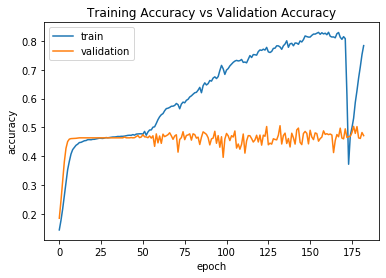

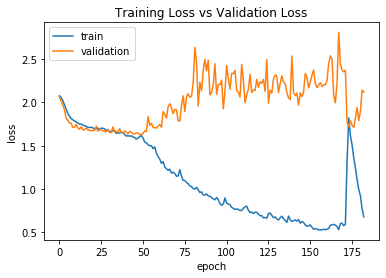

<Figure size 432x288 with 0 Axes>

In [8]:
#Graficos
'''
#Matriz de confusion
lab = [x for x in range(0,num_class)]
matrix = multilabel_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), labels = lab)
print(matrix)

import seaborn as sns

ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax); #annot=True to annotate cells
plt.savefig(fname = "/global/scratch/users/cpezov/AAPBO/models/v4/googleNet-v4/results/confMat.png")
'''
#model.load_weights("/global/scratch/users/cpezov/AAPBO/models/v4/googleNet-v4/models/model.h5") #cargalo de tu ruta
score = model.evaluate(x_test, y_test,verbose=1)
print("MODEL Metric names: ", model.metrics_names)
print("loss:", score[0])
print("accuracy:", score[1])
print("mse:", score[2])

print("HISTORY Keys: ", gglNet_HISTORY.history.keys())
plt.figure(0)
plt.plot(gglNet_HISTORY.history['acc'])
plt.plot(gglNet_HISTORY.history['val_acc'])
plt.title("Training Accuracy vs Validation Accuracy") 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(main_path+'models/v4/googleNet-v4/results/acc_graph.png')

# summarize history for loss
plt.figure(1)
plt.plot(gglNet_HISTORY.history['loss'])
plt.plot(gglNet_HISTORY.history['val_loss'])
plt.title("Training Loss vs Validation Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig(main_path+'models/v4/googleNet-v4/results/loss_graph.png')

# Prediction Time

In [6]:
#Load model

# load json and create model
json_file = open(main_path+"models/v4/googleNet-v4/models/model.json", 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)

# load weights into new model
model.load_weights(main_path+"models/v4/googleNet-v4/models/model.h5")
print("Loaded model from disk")

loss="categorical_crossentropy"
opt = Adam(lr = 0.0001,epsilon=1e-08)

model.compile(loss=loss, optimizer=opt, metrics=['acc', 'mse'])      
model.summary() #ver resumen red

Loaded model from disk
Model: "GoogleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 125, 125, 64) 3200        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 62, 62, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 62, 62, 64)   4160        max_pooling2d[0][0]              
___________________________________________________________________

In [7]:
#Verify model has same metrics

y_pred_onehot = model.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred_onehot, axis=2)

score = model.evaluate(x_test, y_test,verbose=1)
print("MODEL Metric names: ", model.metrics_names)
print("loss:", score[0])
print("accuracy:", score[1])
print("mse:", score[2])

34/34 [==============================] - 1s 17ms/step - loss: 2.0466 - acc: 0.4932 - mse: 0.0884
MODEL Metric names:  ['loss', 'acc', 'mse']
loss: 2.0466086864471436
accuracy: 0.4931899309158325
mse: 0.08839842677116394


In [8]:
#Calcular tiempos de predicción por cada par instancia-tiempo de test
#(Correr esto se demora 1 hora aprox)

now=datetime.datetime.now()
print(now)

l=int(len(y_pred))
t_preds=np.empty(l*500) #Una predicción da los resultados de todos los 500 timesteps

#prediccion
for i in range(len(x_test)):
    #crear np.array de solo esa instancia-timestep
    x_i = [x_test[i]]
    x_i = np.array(x_i)
    
    #hacer predicción y medir tiempo
    start=time.time()
    y_i = model.predict(x_i)
    tiempo=time.time()-start
    #Por cada instancia, guardar el mismo tiempo de predicción para los 500 timesteps (para obtener el resultado de 1 timestep, el modelo debe obtener la predicción para todos los timesteps, por lo que el tiempo que toma es el mismo para todos los timesteps)
    for j in range(500): 
        t_preds[500*i+j]=tiempo

2024-03-05 17:19:28.591690


In [9]:
#Guardar tiempos de prediccion

print(t_preds)
f = open(main_path+"models/results-v4/pred_times/t_pred_googleNet-v4.txt", "w")
np.savetxt(f, t_preds, delimiter=" ", fmt="%s")
f.close()

[0.24367619 0.24367619 0.24367619 ... 0.07071996 0.07071996 0.07071996]


In [10]:
now=datetime.datetime.now()
print(now)

2024-03-05 17:20:47.445289
